In [1]:
import numpy as np
import frbassociate
import frbs
from astropy.wcs import WCS
from astropy import units
from astropy import coordinates as coords
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from photutils import datasets
from frb import *
import photutils
import importlib
from astropy.stats import gaussian_fwhm_to_sigma
import matplotlib.pyplot as plt
importlib.reload(frbs)

<module 'frbs' from '/Users/tarraneh/Dropbox/FRB/frb/associate/frbs.py'>

In [2]:
class FRBAssociate():

    def __init__(self, frb, image_file=None, max_radius=1e9):
        self.frb = frb
        self.image_file = image_file
        self.max_radius = max_radius

        # Attributes
        self.hdu = None
        self.wcs = None
        self.theta_max = None
        self.Pchance = None
        self.theta_prior = None

    @property
    def sigR(self):
        return np.sqrt(self.frb.sig_a * self.frb.sig_b) * units.arcsec

    @property
    def frb_eellipse(self):
        return dict(a=self.frb.sig_a,
                    b=self.frb.sig_b,
                    theta=self.frb.eellipse['theta'])

    def load_image(self):
        """
        Load the image from self.image_file

        Returns:

        """

        if self.image_file is None:
            raise IOError("Set image_file before calling this method")
        self.hdu = fits.open(self.image_file)[0]
        self.wcs = astropy_wcs.WCS(self.hdu.header)
        self.header = self.hdu.header

    def calc_pchance(self, ndens_eval='bloom', extinction_correct=False):
        """
        Calculate the Pchance values for the candidates

        self.Pchance filled in place
        Addes as P_c to candidates

        Args:
            ndens_eval:

        Returns:

        """
        # Correct for extinction
        if extinction_correct and self.filter+'_orig' not in self.candidates.keys():
            ebv = nebular.get_ebv(self.frb.coord, definition='SandF')['meanValue']
            linear_ext = photom.extinction_correction(self.filter, ebv)
            self.candidates[self.filter+'_orig'] = self.candidates[self.filter].values.copy()
            self.candidates[self.filter] += -2.5*np.log10(linear_ext)
        # Do it
        self.Pchance = chance.pchance(self.candidates[self.filter],
                                        self.candidates['separation'],
                                        self.candidates['half_light'],
                                        self.sigR.to('arcsec').value, ndens_eval=ndens_eval)

        # Add to table
        self.candidates['P_c'] = self.Pchance

    def calc_priors(self, prior_U, method='linear'):
        """
        Calulate the priors based on Pchance
        and the input method

        prior_Mi and prior_S are set in place
        The candidates table is updated with P_O

        Args:
            prior_S (float):
                If the input value is <0, use the P_c product else use the input value
            method (str, optional):
                'linear':  P(O) = 1 - Pchance
                'inverse':  P(O) = 1 / Pchance

        Returns:

        """

        if self.Pchance is None:
            raise IOError("Set Pchance before calling this method")

        if prior_U < 0.:
            self.prior_U = np.product(self.candidates['P_c'])
        else:
            self.prior_U = prior_U
        # Raw priors
        self.raw_prior_Oi = bayesian.raw_prior_Oi(self.Pchance, method)

        # Normalize
        self.prior_Oi = bayesian.renorm_priors(self.raw_prior_Oi, self.prior_U)

        # Add to table
        self.candidates['P_O'] = self.prior_Oi

    def calc_POx(self):
        """
        Calculate p(O|x) by running through
        the series of:
            self.calc_pxO()
            self.calc_pxS()
            self.calc_px()

        Values are stored in self.P_Oix
        and the candidates table as P_Ox
        """

        # Intermediate steps
        self.calc_pxO()
        self.calc_pxU()
        self.calc_px()

        # Finish
        self.P_Oix = self.prior_Oi * self.p_xOi / self.p_x
        self.candidates['P_Ox'] = self.P_Oix

        # P(S|x)
        self.P_Ux = self.prior_U * self.p_xU / self.p_x

    def calc_pxO(self):
        """
        Calculate p(x|O) and assign to p_xOi
        """
        self.p_xOi = bayesian.px_Oi(self.max_radius,
                              self.frb.coord, self.frb_eellipse,
                              self.candidates['coords'].values,
                              self.theta_prior)

    def calc_pxU(self):
        """
        Calculate p(x|U) and assign to p_xU
        """
        self.p_xU = bayesian.px_Oi(self.max_radius,
                                   self.frb.coord,
                                   self.frb_eellipse,
                                   SkyCoord([self.frb.coord]),
                                   self.theta_prior)[0]

    def calc_px(self):
        self.p_x = self.prior_U * self.p_xU + np.sum(self.prior_Oi * self.p_xOi)

    def cut_candidates(self, plate_scale, bright_cut=None, separation=None):
        """
        Cut down to candidates

        self.candidates is made in place

        Args:
            plate_scale:
            bright_cut:
            separation:

        Returns:

        """

        # Zero point
        if isinstance(plate_scale, str):
            plate_scale = self.header[plate_scale]

        if self.photom is None:
            raise ValueError("photom table not built!")

        cands = np.ones(len(self.photom), dtype=bool)

        # Cut on brightness?
        if bright_cut is not None:
            good_bright = self.photom[self.filter] > bright_cut
            cands &= good_bright

        # Candidate table
        self.candidates = self.photom[cands]

        # Add coords
        coords = astropy_wcs.utils.pixel_to_skycoord(
            self.candidates['xcentroid'],
            self.candidates['ycentroid'],
            self.wcs)
        # Insist on ICRS
        coords = coords.transform_to('icrs')

        self.candidates['ra'] = coords.ra
        self.candidates['dec'] = coords.dec
        self.candidates['coords'] = coords

        # Separation
        seps = self.frb.coord.separation(coords)
        self.candidates['separation'] = seps.to('arcsec')

        # Cut on separation?
        if separation is not None:
            cut_seps = seps < separation
            self.candidates = self.candidates[cut_seps]

        # Half light
        self.candidates['half_light'] = self.candidates['semimajor_axis_sigma'] * plate_scale

    def photometry(self, ZP, ifilter, radius=3., show=False, outfile=None):
        """
        Perform photometry

        Args:
            ZP (float):
                Zero point magnitude
            ifilter (str):
            radius:
            show:
            outfile:

        Returns:

        """

        # Init
        if self.segm is None:
            raise ValueError("segm not set!")
        if self.hdu is None:
            self.load_image()

        # Zero point
        if isinstance(ZP, str):
            ZP = self.header[ZP]

        self.cat = photutils.source_properties(self.hdu.data - self.bkg.background,
                                               self.segm,
                                               background=self.bkg.background,
                                               filter_kernel=self.kernel)

        # Apertures
        apertures = []
        for obj in self.cat:
            position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
            a = obj.semimajor_axis_sigma.value * radius
            b = obj.semiminor_axis_sigma.value * radius
            theta = obj.orientation.to(units.rad).value
            apertures.append(photutils.EllipticalAperture(position, a, b, theta=theta))
        self.apertures = apertures

        # Magnitudes
        self.filter = ifilter
        self.photom = self.cat.to_table().to_pandas()
        self.photom[ifilter] = -2.5 * np.log10(self.photom['source_sum']) + ZP

        # Plot?
        if show or outfile is not None:
            norm = ImageNormalize(stretch=SqrtStretch())
            fig = plt.figure(figsize=(9, 9))

            # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
            plt.clf()
            ax1 = plt.gca()
            ax1.imshow(self.hdu.data, origin='lower', cmap='Greys_r', norm=norm)
            ax1.set_title('Data')
            #
            for aperture in apertures:
                aperture.plot(axes=ax1, color='white', lw=1.5)
            if outfile is not None:  # This must come first
                plt.savefig(outfile, dpi=300)
            if show:
                plt.show()

    def segment(self, nsig=3., xy_kernel=(3,3), npixels=3, show=False, outfile=None,
                deblend=False):
        """
        Generate the segment image

        Args:
            nsig (float):
                Kernel parameter
            xy_kernel:
                Kernel parameter
            npixels:
            show:
            outfile:
            deblend (bool, optional):
                Run deblend algorithm too

        Returns:

        """

        if self.thresh_img is None:
            raise ValueError("Threshold image not set!")
        if self.hdu is None:
            self.load_image()

        # Kernel
        sigma = nsig * gaussian_fwhm_to_sigma
        self.kernel = Gaussian2DKernel(sigma, x_size=xy_kernel[0], y_size=xy_kernel[1])  # Might need a somewhat larger one
        self.kernel.normalize()

        # Segment
        self.segm = photutils.detect_sources(self.hdu.data, self.thresh_img,
                                             npixels=npixels, filter_kernel=self.kernel)

        # Debelnd?
        if deblend:
            segm_deblend = photutils.deblend_sources(self.hdu.data, self.segm,
                                                     npixels=npixels,
                                                     filter_kernel=self.kernel,
                                                     nlevels=32,
                                                     contrast=0.001)
            self.orig_segm = self.segm.copy()
            self.segm = segm_deblend


        # Show?
        if show or outfile is not None:
            fig = plt.figure(figsize=(7, 7))

            ax = plt.gca()
            cmap = self.segm.make_cmap()
            ax.imshow(self.segm, origin='lower', cmap=cmap, interpolation='nearest')
            ax.set_title('Segmentation Image')

            if outfile is not None:  # This must come first
                plt.savefig(outfile, dpi=300)
            if show:
                plt.show()

    def set_theta_prior(self, theta_dict):
        """

        Args:
            theta_dict (dict):

        """
        self.theta_max = theta_dict['max']
        self.theta_prior = theta_dict

    def threshold(self, nsig=1.5, box_size=(50,50), filter_size=(3,3)):
        """
        Generate threshold image

        self.thresh_img is set in place

        Args:
            nsig (float, optional):
                Primary threshold parameter
            box_size (tuple):
                Primary Background2D parameter
            filter_size (tuple):
                Primary Background2D parameter
        Returns:

        """

        if self.hdu is None:
            self.load_image()

        # Background
        bkg_estimator = photutils.MedianBackground()
        self.bkg = photutils.Background2D(self.hdu.data, box_size,
                                          filter_size=filter_size,
                                          bkg_estimator=bkg_estimator)

        # Threshold
        self.thresh_img = self.bkg.background + (nsig * self.bkg.background_rms)

    def __repr__(self):
        txt = '<{:s}: {}'.format(self.__class__.__name__, self.frb.frb_name)
        # Finish
        txt = txt + '>'
        return (txt)

In [243]:
config = frbs.frb200430
config

FRB = frb.FRB.by_name(config['name'])
frbA= FRBAssociate(FRB, max_radius=config['max_radius'])

hdul = fits.open(config['image_file'])
hdu_full = hdul[0]
size = units.Quantity((config['cut_size'], config['cut_size']), units.arcsec)
w = WCS(hdu_full.header)

cutout = Cutout2D(hdu_full.data, FRB.coord, size, wcs=w)
frbA.wcs = cutout.wcs
frbA.hdu = hdu_full.data
frbA.header = hdu_full.header

print(w)


bkg_estimator = photutils.MedianBackground()
back = photutils.Background2D(frbA.hdu.data, box_size=(50,50),
                                          filter_size=(3,3),
                                          bkg_estimator=bkg_estimator)
nsig = 1.5
back.background + (nsig * back.background_rms)



FileNotFoundError: [Errno 2] No such file or directory: '/Users/tarraneh/opt/anaconda3/lib/python3.8/site-packages/FRB-0.1.dev0-py3.8.egg/frb/data/FRBs/FRB200430.json'

In [241]:
config = frbs.frb190608
config

FRB = frb.FRB.by_name(config['name'])
frbA= FRBAssociate(FRB, max_radius=config['max_radius'])

hdul = fits.open(config['image_file'])
hdu_full = hdul[0]
size = units.Quantity((config['cut_size'], config['cut_size']), units.arcsec)
w = WCS(hdu_full.header)

cutout = Cutout2D(hdu_full.data, FRB.coord, size, wcs=w)
frbA.wcs = cutout.wcs
frbA.hdu = cutout
frbA.header = WCS(hdu_full.header)



bkg_estimator = photutils.MedianBackground()
back = photutils.Background2D(frbA.hdu.data, box_size=(50,50),
                                          filter_size=(3,3),
                                          bkg_estimator=bkg_estimator)
nsig = 1.5
back.background + (nsig * back.background_rms)

array([[47.40178776, 47.40179446, 47.40181444, ..., 47.45274767,
        47.45275972, 47.45276831],
       [47.4017846 , 47.40179131, 47.40181129, ..., 47.45275542,
        47.45276748, 47.45277607],
       [47.40177514, 47.40178185, 47.40180184, ..., 47.45277827,
        47.45279035, 47.45279897],
       ...,
       [47.32410504, 47.32410802, 47.32411696, ..., 47.40794362,
        47.40799409, 47.40803032],
       [47.32403495, 47.32403794, 47.32404692, ..., 47.40795611,
        47.40800665, 47.40804293],
       [47.32398448, 47.32398747, 47.32399647, ..., 47.40796546,
        47.40801605, 47.40805238]])

In [194]:
    def threshold(self, nsig=1.5, box_size=(50,50), filter_size=(3,3)):
        """
        Generate threshold image

        self.thresh_img is set in place

        Args:
            nsig (float, optional):
                Primary threshold parameter
            box_size (tuple):
                Primary Background2D parameter
            filter_size (tuple):
                Primary Background2D parameter
        Returns:

        """

        if self.hdu is None:
            self.load_image()

        # Background
        bkg_estimator = photutils.MedianBackground()
        self.bkg = photutils.Background2D(self.hdu.data, box_size,
                                          filter_size=filter_size,
                                          bkg_estimator=bkg_estimator)

        # Threshold
        self.thresh_img = self.bkg.background + (nsig * self.bkg.background_rms)
        

    def __repr__(self):
        txt = '<{:s}: {}'.format(self.__class__.__name__, self.frb.frb_name)
        # Finish
        txt = txt + '>'
        return (txt)
    
    
threshold(frbA)

ValueError: The number of values must match the number of coordinates.

In [182]:
coordinates = np.atleast_2d(FRB.coord)


if coordinates.shape[0] == 1:
    coordinates = np.transpose(coordinates)
    
coordinates.ndim
values = np.asanyarray(values).ravel()
ncoords = coordinates.shape[0]
values.shape[0]

2475812

In [246]:
config = frbs.frb200430


FileNotFoundError: [Errno 2] No such file or directory: '/Users/tarraneh/opt/anaconda3/lib/python3.8/site-packages/FRB-0.1.dev0-py3.8.egg/frb/data/FRBs/FRB200430.json'

In [269]:
radius = int(3)
radius

3

a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


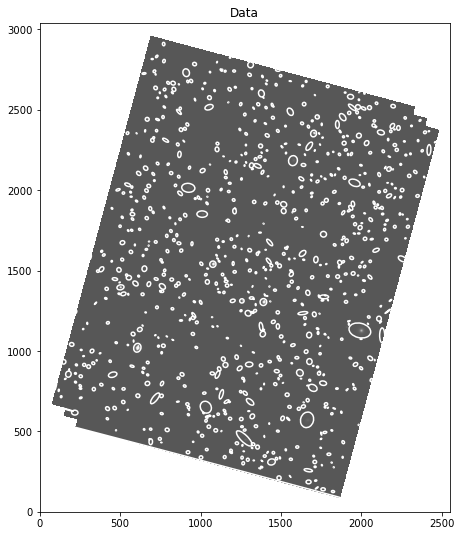

In [280]:
config = frbs.frb200430
#FRB = frb.FRB.by_name(config['name'])
#frbA= FRBAssociate(FRB, max_radius=config['max_radius'])
npixels=config['npixels']
radius = int(3)



hdul = fits.open(config['image_file'])
hdu_full = hdul[0]
size = units.Quantity((config['cut_size'], config['cut_size']), units.arcsec)
w = WCS(hdu_full.header)

#cutout = Cutout2D(hdu_full.data, FRB.coord, size, wcs=w)
#frbA.wcs = cutout.wcs
#frbA.hdu = cutout
#frbA.header = WCS(hdu_full.header)


bkg_estimator = photutils.MedianBackground()
back = photutils.Background2D(hdu_full.data, box_size=(50,50),
                                          filter_size=(3,3),
                                          bkg_estimator=bkg_estimator)

nsig = 1.5
thres = back.background + (nsig * back.background_rms)

sigma = 3. * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3) 
kernel.normalize()

segm = photutils.detect_sources(hdu_full.data, thres,
                                             npixels=npixels, filter_kernel=kernel)

source_props = photutils.source_properties(hdu_full.data - back.background,
                                               segm,
                                               background=back.background,
                                               filter_kernel=kernel)

apertures = []
for obj in source_props:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * radius
    b = obj.semiminor_axis_sigma.value * radius
    theta = obj.orientation.to(units.rad).value
    apertures.append(photutils.EllipticalAperture(position, a, b, theta=theta))
    
source_props.to_table().to_pandas()

norm = ImageNormalize(stretch=SqrtStretch())
fig = plt.figure(figsize=(9, 9))

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))

ax1 = plt.gca()
ax1.imshow(hdu_full.data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')

for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)

plt.show()


In [325]:
table = source_props.to_table().to_pandas()
#table[table['xcentroid']==1539]
input = 2477
table.iloc[(table['ycentroid']-input).abs().argsort()[:2]]

,id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,...,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
723,724,1924.523478,2480.407801,None,None,86178.418054,None,-251.850183,-0.883685,-0.908759,...,0.258327,0.033943,1.035135,10.718664,0.366451,10.849538,0.093403,-0.006310,0.092276,0.55259
721,722,1275.350615,2470.698769,None,None,10009.121160,None,-44.264161,-0.413684,-0.412860,...,0.536683,0.156216,1.185138,6.273699,0.784880,8.117021,0.161347,-0.031203,0.124707,0.28417


In [311]:
catalog = datasets.load_spitzer_catalog()
positions = SkyCoord(catalog['l'], catalog['b'], frame='galactic')

In [307]:
from astroquery.sdss import SDSS
pos = coords.SkyCoord('229.705146 +12.354299', frame='icrs',unit='deg')
xid = SDSS.query_region(pos, spectro=True)
print(xid)

None


In [329]:
20.6989 +13.5446

34.2435

In [331]:
np.average([34.2435,34.04,33.739])

34.0075

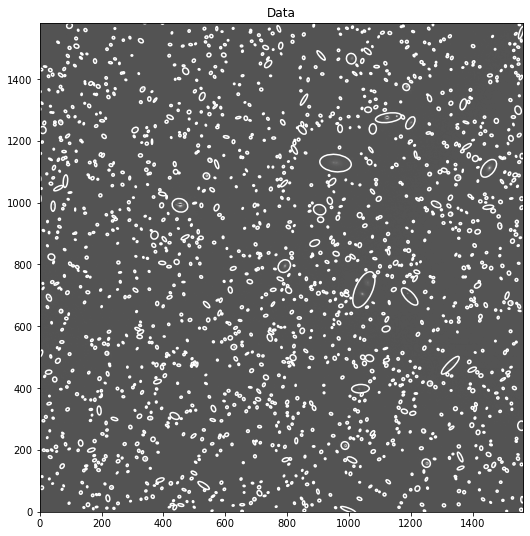

In [3]:
config = frbs.frb190608
#FRB = frb.FRB.by_name(config['name'])
#frbA= FRBAssociate(FRB, max_radius=config['max_radius'])
npixels=config['npixels']
radius = int(3)



hdul = fits.open(config['image_file'])
hdu_full = hdul[0]
size = units.Quantity((config['cut_size'], config['cut_size']), units.arcsec)
w = WCS(hdu_full.header)

#cutout = Cutout2D(hdu_full.data, FRB.coord, size, wcs=w)
#frbA.wcs = cutout.wcs
#frbA.hdu = cutout
#frbA.header = WCS(hdu_full.header)


bkg_estimator = photutils.MedianBackground()
back = photutils.Background2D(hdu_full.data, box_size=(50,50),
                                          filter_size=(3,3),
                                          bkg_estimator=bkg_estimator)

nsig = 1.5
thres = back.background + (nsig * back.background_rms)

sigma = 3. * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3) 
kernel.normalize()

segm = photutils.detect_sources(hdu_full.data, thres,
                                             npixels=npixels, filter_kernel=kernel)

source_props = photutils.source_properties(hdu_full.data - back.background,
                                               segm,
                                               background=back.background,
                                               filter_kernel=kernel)

apertures = []
for obj in source_props:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * radius
    b = obj.semiminor_axis_sigma.value * radius
    theta = obj.orientation.to(units.rad).value
    apertures.append(photutils.EllipticalAperture(position, a, b, theta=theta))
    
source_props.to_table().to_pandas()

norm = ImageNormalize(stretch=SqrtStretch())
fig = plt.figure(figsize=(9, 9))

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))

ax1 = plt.gca()
ax1.imshow(hdu_full.data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')

for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)

plt.show()


In [14]:
table = source_props.to_table().to_pandas()
input = 308.53053
table.iloc[(table['xcentroid']-input).abs().argsort()[:10]]

,id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,...,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
1301,1302,308.130700,1234.704219,None,None,1812.178959,None,15990.592750,46.484281,46.483463,...,0.695742,0.281708,1.392191,11.178027,3.025909,8.982963,0.098437,-0.066317,0.122491,0.676961
344,345,307.794054,327.580575,None,None,8.312660,None,515.095930,46.826903,46.826925,...,0.716662,0.302580,1.433855,0.720569,-0.264415,0.869133,1.562192,0.950525,1.295161,0.222120
760,761,309.439300,716.676228,None,None,301.518099,None,4974.124500,46.925703,46.925640,...,0.831454,0.444407,1.799879,6.589182,-2.791344,4.618278,0.203996,0.246595,0.291054,0.605450
823,824,307.203206,777.301097,None,None,14.792730,None,938.138308,46.906915,46.906949,...,0.684894,0.271357,1.372415,1.083838,-0.273832,1.762609,0.960342,0.298390,0.590519,0.254193
1111,1112,310.188188,1051.340587,None,None,5.415476,None,420.688285,46.743143,46.743174,...,0.630768,0.224028,1.288707,0.499343,-0.095969,0.739905,2.053829,0.532784,1.386077,0.344491
443,444,306.427938,410.609521,None,None,11.162286,None,702.964506,46.864300,46.864253,...,0.700701,0.286545,1.401630,0.921381,0.316556,1.176419,1.195885,-0.643589,0.936627,0.315792
877,878,310.657122,826.020273,None,None,8.200688,None,515.816950,46.892450,46.892473,...,0.688804,0.275052,1.379409,0.999314,-0.133182,0.584848,1.032008,0.470021,1.763364,0.241335
990,991,311.511480,926.241418,None,None,23.567229,None,1124.161123,46.840047,46.839975,...,0.416394,0.090816,1.099887,1.530918,-0.018305,1.267796,0.653316,0.018866,0.788907,0.431602
1287,1288,305.331842,1214.052811,None,None,12.972590,None,837.332490,46.518472,46.518483,...,0.763637,0.354354,1.548837,1.072851,-0.481419,1.630060,1.074495,0.634679,0.707197,0.193787
688,689,312.920303,647.416489,None,None,7.678716,None,563.312738,46.942728,46.942727,...,0.608822,0.206693,1.260546,0.794840,0.180796,0.968588,1.313900,-0.490503,1.078209,0.288538


In [15]:
19.568300247192383+2.5*np.log10(1812.178959	)

27.713802956080315

In [18]:
np.average([27.802392768370396,
27.843751506211003,
28.42635448931852,
27.729254855064177,
27.713802956080315])

27.90311131500888